In [1]:
import pandas as pd
import numpy as np
import talib
import pandas_profiling as pdp
import sweetviz as sv

import os
import sys
from pygam import s, LinearGAM
import category_encoders as ce
from typing import List, Dict

import matplotlib.pyplot as plt
import seaborn as sns

import ptitprince
from matplotlib_venn import venn2
plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro"

from common_module.utils.plot import (
    plot_venn,
    plot_histogram,
    plot_raincloud,
    plot_heatmap,
    plot_histgram_for_valid,
    plot_lineargam,
    plot_feature_importance_for_valid
)
from common_module.utils.summarize import (
    get_pandas_profiling,
    get_sweetviz_report
)
from common_module.utils.preprocessor import (
    OrdinalEncodingBlock,
    CountEncodingBlock,
    GroupingBlock
)
from common_module.utils.format_df import format_df
from common_module.utils.utils import (
    reduce_mem_usage,
    save_pickle,
    load_pickle
)

from probspace_usstock.modules.config_manager import ConfigManager
from probspace_usstock.modules.features import (
    create_company_features,
    # calc_Symbol_lag_features,
    # calc_Symbol_lag_log_features,
    # calc_List_lag_features,
    # calc_Symbol_lag_log1pRate_features,
    # calc_category_lag_log1pRate_features,
    calc_Symbol_lag_residual_features,
    calc_category_lag_residual_features,
    calc_std_features,
    create_percentile_flg_columns,
    create_ymd_features
)
from probspace_usstock.modules.preprocessor import (
    melt_dataframe,
    create_base_dataframe,
    calc_seasonal_decompose
)
from probspace_usstock.modules.parameter_tuner import OptunaParameterTuning
from probspace_usstock.modules.train_module import (
    TrainLGBModule,
    TrainCABModule,
    TrainXGBModule
)
from probspace_usstock.modules.predict import (
    make_pred_df,
    PredictModule
)

sys.path.append("../")
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 100)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/Users/saitouteruaki/.local/share/virtualenvs/data_science-EJAMj-NW/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# read
df_train_origin = pd.read_csv("../input/train_data.csv", encoding="utf-8-sig")
df_company_list_origin = pd.read_csv("../input/company_list.csv", encoding="utf-8-sig")
df_sub_template = pd.read_csv("../input/submission_template.csv", encoding="utf-8-sig")

# shape
display(df_train_origin.shape)
display(df_company_list_origin.shape)
display(df_sub_template.shape)

(420, 3279)

(7007, 6)

(3278, 2)

In [3]:
print("■train_data")
display(df_train_origin.shape)
display(df_train_origin.head(4))

print("■company_list")
display(df_company_list_origin.shape)
display(df_company_list_origin.head(1))

print("■submission_template")
display(df_sub_template.shape)
display(df_sub_template.head(1))

■train_data


(420, 3279)

,Date,VGSH,JEF,IVZ,KTCC,FBZ,PLOW,JBK,IAC,IVR,VSH,VCV,OKE,ROK,FTAG,BRKR,GSK,JPS,SRPT,VMI,IMKTA,BDR,JAKK,MVC,AMSF,APTO,CNX,XOMA,LBY,BIOL,PAAS,KOF,LAC,EML,IVC,TILE,IEF,CSV,QADA,TBNK,HOG,WIW,SVBI,PKOH,CREG,LOGM,ERII,PEBO,PEER,ORA,RIO,BPOPM,PDLI,RYN,UNAM,PFD,CALX,SNSS,TCF,MTRX,AVGO,MSM,REV,HSY,PEP,REED,HPQ,BKTI,MPB,AAON,PSO,CIG,NAC,OPNT,RE,SES,RTN,WST,HIHO,FLC,EFT,DCI,IIF,BANC,CRS,GAIN,UHT,TMO,MFNC,TEX,LTBR,QGEN,EVV,BBY,MRKR,CSQ,KBAL,QRHC,ANIP,FMBH,...,CONN,EGO,CY,ICLN,NNVC,AIZ,XAN,ALIM,PFL,WIA,TRST,EXD,HNW,SBLK,AUBN,GSIT,ISSC,ESGR,CAMT,CKH,CLS,ZTR,SIRI,PFM,ANTE,PZC,DSLV,WDC,PRPH,RS,BOTJ,CE,HAIN,QCLN,ATR,WSM,LNG,VTWO,FRC,FUL,ICFI,CIZN,UFI,MXIM,MRLN,GTT,CR,SXT,NBTB,ADI,EVK,WSBC,ACER,CHN,CORT,FLIC,ADTN,PFLT,AVID,TSEM,KRO,MORN,BHV,MMU,SGRP,PBA,GF,OSPN,J,AMKR,CPHI,TRT,OPRX,DXYN,GFED,FRAF,HWCC,WYND,CHMG,EVC,NNA,IOR,ATLC,STWD,TTM,NOC,EQS,MKC,MXL,NEV,ASFI,JTA,MNR,TFSL,GTN,TYG,VIRC,BIS,WOOD,MASI
0,2011/11/13,55.942184,17.649006,13.770864,4.77,13.818835,10.198389,12.440549,38.484608,4.836254,8.575465,7.877108,23.100210,59.334507,84.253273,11.731660,28.273636,4.168243,4.86,75.028809,12.110400,1.13,18.456266,7.713052,15.194721,2.88,29.963728,30.400000,10.973586,14.384466,20.405405,73.412354,1.75,16.415005,19.071070,10.358725,88.829475,5.339281,10.804994,15.035470,29.228592,9.278417,2.594832,17.814543,14.5,38.607750,2.50,9.508274,22.400000,17.544151,34.077663,9.051845,4.036423,21.052782,10.179731,7.213885,8.41,7.50,14.216700,9.68,24.646343,50.906437,14.46,46.303482,49.788853,1.39,8.927394,0.877275,6.139855,8.682248,12.204165,3.919564,8.690806,0.42,73.116982,98.559998,35.922192,17.122187,1.637933,9.453785,8.308208,28.895016,9.979239,8.690458,45.424389,3.396492,23.906984,44.114647,3.987525,13.897991,187.800003,13.728254,7.737930,21.358797,288.0,4.088526,3.683195,18.000000,84.599998,14.962660,...,9.95,83.039902,13.923010,7.072347,55.299999,31.703871,11.661029,1.29,4.546225,9.558780,3.620234,7.187960,8.973720,84.834564,14.881336,4.86,3.010909,96.360001,1.812006,58.838348,8.25,4.215335,1.700923,11.964488,14.300000,5.702804,43.799999,20.713301,0.762946,36.546154,4.475960,35.595501,17.670000,9.581954,42.146973,29.780903,11.70,51.195068,22.606068,20.090033,24.530502,11.557922,7.89,19.594046,8.667803,1.36,38.136402,30.210152,15.731730,28.358801,1.37,15.125630,373.333344,10.369422,3.39,9.227671,27.211815,5.037442,7.10,10.65,12.701912,53.690952,13.001904,8.411827,1.22,16.457903,6.239215,8.04,39.470684,4.63,0.88,2.40,3.06,2.93,4.992733,10.988591,9.748321,10.293147,17.453051,1.078169,33.496590,1.92,3.16,6.810544,15.831424,47.542465,2.21,40.948685,4.96,8.450615,3.721562,4.747546,5.567790,7.262252,1.80,20.079035,1.504111,826.767029,30.918266,18.430309
1,2011/11/20,55.978844,16.270664,12.719761,4.94,12.744166,10.035272,12.065370,36.252533,4.658076,7.657301,7.939425,22.540537,55.720310,78.528595,11.262002,27.104542,4.072667,4.08,69.938858,11.282884,1.14,17.461733,6.991731,14.490328,2.52,27.630514,30.799999,10.061356,12.466537,20.022963,68.245247,1.65,16.306412,18.346851,8.876307,89.084717,5.274280,9.564995,14.278780,27.989960,9.314977,2.662356,15.294662,12.5,34.829571,2.27,7.991528,22.400000,15.904687,30.586075,9.023554,4.063376,19.843987,10.206950,7.154890,7.18,6.90,12.750013,8.53,23.474276,48.047035,13.74,45.746265,48.697853,1.40,8.098125,0.919861,6.164315,7.810735,11.651024,3.674882,8.618720,0.40,69.981857,89.599998,35.203728,16.185606,1.494254,9.253301,8.163390,27.018999,9.378841,7.772503,41.059013,3.186542,22.347122,42.692211,4.068903,11.817956,160.800003,13.438292,7.711720,20.230078,264.0,3.903125,3.333358,19.600000,79.919998,15.667272,...,10.10,79.030418,12.645804,6.734447,49.700001,30.477777,11.191008,1.19,4.488735,9.543862,3.398002,7.272264,8.764602,84.780708,14.881336,4.69,2.892424,91.690002,1.634359,56.146488,7.54,4.132953,1.672256,11.491554,15.050000,5.714909,47.240002,19.886042,0.835607,35.020405,3.670286,35.281651,17.620001,8.790443,40.813152,28.370873,10.21,47.593803,21.723381,18.736162,23.587021,11.517131,7.39,18.258261,7.567554,1.30,36.288921,

■company_list


(7007, 6)

,Symbol,Name,IPOyear,Sector,Industry,List
0,XXII,"22nd Century Group, Inc",NaN,Consumer Non-Durables,Farming/Seeds/Milling,AMEX


■submission_template


(3278, 2)

,id,y
0,VGSH,NaN


## baseとなるdataframeを作成する

In [32]:
config_path = "../config/setting.yaml"
config_manager = ConfigManager(config_path=config_path)

In [5]:
# company関連の特徴量を先に作ってListをマージしたい
df_company_features = create_company_features(
    input=df_company_list_origin,
    duplicate_companies=config_manager.duplicate_companies
)
display(df_company_features.head(2))
display(df_company_features.shape)

,Symbol,IPOyear,List,Sector,Industry
0,XXII,NaN,AMEX,Consumer Non-Durables,Farming/Seeds/Milling
1,FAX,1986.0,AMEX,unknown,unknown


(6991, 5)

In [6]:
df_base = melt_dataframe(input=df_train_origin)
df_base = create_base_dataframe(input=df_base, df_company=df_company_features)

# company_listに登録されていない会社があるので情報をunknownで埋める
for cat in ["List", "Sector", "Industry"]:
    df_base[cat] = df_base[cat].fillna("unknown")

# トレンド、季節成分、残差を求める
df_ymd = create_ymd_features(input=df_base)
df_tsr = calc_seasonal_decompose(input_df=df_base, ymd_df=df_ymd, period=53)

# トレンド、季節成分、残差をbaseにマージする
df_base = pd.merge(df_base, df_tsr.drop("week_of_year", axis=1), how="left", on=["Date", "Symbol"])
display(df_base.tail(2))
display(df_base.info())

,Date,Symbol,stock_price,List,Sector,Industry,trend,seasonality,residual
1376758,2019/11/24,WOOD,NaN,NASDAQ,unknown,unknown,59.997331,1.527599,NaN
1376759,2019/11/24,MASI,NaN,NASDAQ,Health Care,Biotechnology: Electromedical & Electrotherape...,136.195660,6.092730,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376760 entries, 0 to 1376759
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Date         1376760 non-null  object 
 1   Symbol       1376760 non-null  object 
 2   stock_price  1373482 non-null  float64
 3   List         1376760 non-null  object 
 4   Sector       1376760 non-null  object 
 5   Industry     1376760 non-null  object 
 6   trend        1203026 non-null  float64
 7   seasonality  1376760 non-null  float64
 8   residual     1199748 non-null  float64
dtypes: float64(4), object(5)
memory usage: 105.0+ MB


None

Text(0, 0.5, 'residual')

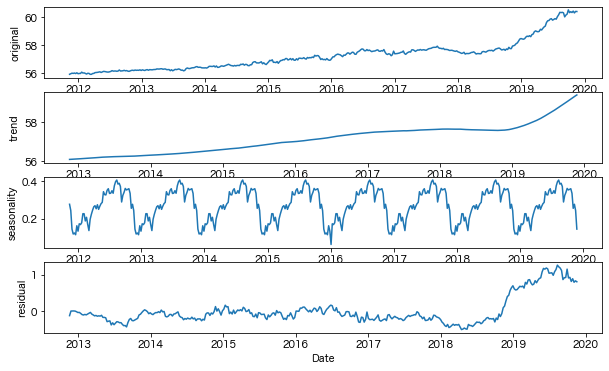

In [18]:
target_symbol = "VGSH"

df_single = df_base[df_base["Symbol"] == target_symbol].copy()

plt.figure(figsize=(10,6))

plt.subplot(4,1,1)
sns.lineplot(x=pd.to_datetime(df_single["Date"]), y=df_single["stock_price"])
plt.ylabel("original")

plt.subplot(4,1,2)
sns.lineplot(x=pd.to_datetime(df_single["Date"]), y=df_single["trend"])
plt.ylabel("trend")

plt.subplot(4,1,3)
sns.lineplot(x=pd.to_datetime(df_single["Date"]), y=df_single["seasonality"])
plt.ylabel("seasonality")

plt.subplot(4,1,4)
sns.lineplot(x=pd.to_datetime(df_single["Date"]), y=df_single["residual"])
plt.ylabel("residual")

## 特徴量作成

In [7]:
%%time

df_ymd = create_ymd_features(input=df_base)
df_standard = calc_std_features(input=df_base)
df_Symbol_lag = calc_Symbol_lag_residual_features(input=df_base)
# df_Symbol_lag = calc_Symbol_lag_log1pRate_features(input=df_base)

target_cols = ["residual_1s", "residual_2s"]
methods = ["mean", "median", "std"]
df_List_lag = calc_category_lag_residual_features(input=df_Symbol_lag, category="List", target_cols=target_cols, methods=methods)
df_Sector_lag = calc_category_lag_residual_features(input=df_Symbol_lag, category="Sector", target_cols=target_cols, methods=methods)
df_Industry_lag = calc_category_lag_residual_features(input=df_Symbol_lag, category="Industry", target_cols=target_cols, methods=methods)
# df_List_lag = calc_category_lag_log1pRate_features(input=df_Symbol_lag, category="List", target_cols=target_cols, methods=methods)
# df_Sector_lag = calc_category_lag_log1pRate_features(input=df_Symbol_lag, category="Sector", target_cols=target_cols, methods=methods)
# df_Industry_lag = calc_category_lag_log1pRate_features(input=df_Symbol_lag, category="Industry", target_cols=target_cols, methods=methods)
# df_flg = create_percentile_flg_columns(input=df_Symbol_lag)

display(df_ymd.head(2))
display(df_Symbol_lag.head(2))
display(df_List_lag.head(2))
display(df_Sector_lag.head(2))
display(df_Industry_lag.head(2))
# display(df_Sector_lag.head(2))
# display(df_flg.head(2))

end making Symbol lag ...
end making List lag ...
end making Sector lag ...
end making Industry lag ...


,Date,year,month,day,week_of_month,week_of_year
0,2011/11/13,2011,11,13,2,45
1,2011/11/20,2011,11,20,3,46


,Date,Symbol,List,Sector,Industry,residual_1s,residual_2s,residual_3s,residual_4s,residual_1s_4r_mean,residual_1s_4r_median,residual_1s_4r_max,residual_1s_4r_min,residual_1s_8r_mean,residual_1s_8r_median,residual_1s_8r_max,residual_1s_8r_min,residual_1s_12r_mean,residual_1s_12r_median,residual_1s_12r_max,residual_1s_12r_min,residual_1s_24r_mean,residual_1s_24r_median,residual_1s_24r_max,residual_1s_24r_min,residual_1s_53r_mean,residual_1s_53r_median,residual_1s_53r_max,residual_1s_53r_min
0,2011/11/13,VGSH,NASDAQ,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/11/20,VGSH,NASDAQ,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Date,List,residual_1s_List_mean,residual_1s_List_median,residual_1s_List_std,residual_2s_List_mean,residual_2s_List_median,residual_2s_List_std
0,2011/11/13,AMEX,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/11/13,NASDAQ,NaN,NaN,NaN,NaN,NaN,NaN


,Date,Sector,residual_1s_Sector_mean,residual_1s_Sector_median,residual_1s_Sector_std,residual_2s_Sector_mean,residual_2s_Sector_median,residual_2s_Sector_std
0,2011/11/13,Basic Industries,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/11/13,Capital Goods,NaN,NaN,NaN,NaN,NaN,NaN


,Date,Industry,residual_1s_Industry_mean,residual_1s_Industry_median,residual_1s_Industry_std,residual_2s_Industry_mean,residual_2s_Industry_median,residual_2s_Industry_std
0,2011/11/13,Accident &Health Insurance,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/11/13,Advertising,NaN,NaN,NaN,NaN,NaN,NaN


CPU times: user 37.4 s, sys: 1.03 s, total: 38.4 s
Wall time: 40 s


In [9]:
%%time

df_merge = pd.merge(df_base, df_company_features.drop(["List", "Sector", "Industry"], axis=1), how="left", on="Symbol")
df_merge = pd.merge(df_merge, df_ymd, how="left", on="Date")
df_merge = pd.merge(df_merge, df_standard, how="left", on=["Date", "Symbol"])
df_merge = pd.merge(df_merge, df_Symbol_lag.drop(["List", "Sector", "Industry"], axis=1), how="left", on=["Date", "Symbol"])
df_merge = pd.merge(df_merge, df_List_lag, how="left", on=["Date", "List"])
df_merge = pd.merge(df_merge, df_Sector_lag, how="left", on=["Date", "Sector"])
df_merge = pd.merge(df_merge, df_Industry_lag, how="left", on=["Date", "Industry"])

# df_merge = pd.merge(df_merge, df_flg, how="left", on=["Date", "Symbol"])

CPU times: user 3.77 s, sys: 2.06 s, total: 5.82 s
Wall time: 6.18 s


In [10]:
df_merge.head()

,Date,Symbol,stock_price,List,Sector,Industry,trend,seasonality,residual,IPOyear,year,month,day,week_of_month,week_of_year,trend_standard,seasonality_standard,residual_1s,residual_2s,residual_3s,residual_4s,residual_1s_4r_mean,residual_1s_4r_median,residual_1s_4r_max,residual_1s_4r_min,residual_1s_8r_mean,residual_1s_8r_median,residual_1s_8r_max,residual_1s_8r_min,residual_1s_12r_mean,residual_1s_12r_median,residual_1s_12r_max,residual_1s_12r_min,residual_1s_24r_mean,residual_1s_24r_median,residual_1s_24r_max,residual_1s_24r_min,residual_1s_53r_mean,residual_1s_53r_median,residual_1s_53r_max,residual_1s_53r_min,residual_1s_List_mean,residual_1s_List_median,residual_1s_List_std,residual_2s_List_mean,residual_2s_List_median,residual_2s_List_std,residual_1s_Sector_mean,residual_1s_Sector_median,residual_1s_Sector_std,residual_2s_Sector_mean,residual_2s_Sector_median,residual_2s_Sector_std,residual_1s_Industry_mean,residual_1s_Industry_median,residual_1s_Industry_std,residual_2s_Industry_mean,residual_2s_Industry_median,residual_2s_Industry_std
0,2011/11/13,VGSH,55.942184,NASDAQ,unknown,unknown,NaN,0.277165,NaN,NaN,2011,11,13,2,45,NaN,0.063596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/11/20,VGSH,55.978844,NASDAQ,unknown,unknown,NaN,0.243586,NaN,NaN,2011,11,20,3,46,NaN,-0.332124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/11/27,VGSH,56.021038,NASDAQ,unknown,unknown,NaN,0.144378,NaN,NaN,2011,11,27,4,47,NaN,-1.501257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/12/4,VGSH,56.002697,NASDAQ,unknown,unknown,NaN,0.118109,NaN,NaN,2011,12,4,1,48,NaN,-1.810821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011/12/11,VGSH,56.030224,NASDAQ,unknown,unknown,NaN,0.123689,NaN,NaN,2011,12,11,2,49,NaN,-1.745074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# NaNがある期間は学習に使用しない
print(df_merge.shape)
df_merge = df_merge[df_merge["residual_1s_53r_mean"].notnull()]
# df_merge = df_merge[df_merge["stock_price_log1pRate_1s_12r_mean"].notnull()]
# df_merge = df_merge[df_merge["stock_price_log1pRate_1s_List_mean"].notnull()]
# df_merge = df_merge[df_merge["stock_price_1s_12r_mean"].notnull()]
print(df_merge.shape)
df_merge = reduce_mem_usage(df_merge)
df_merge.info()

(1376760, 59)
(1029292, 59)
Memory usage of dataframe is 471.17 MB
Memory usage after optimization is: 116.98 MB
Decreased by 75.2%
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029292 entries, 106 to 1376759
Data columns (total 59 columns):
 #   Column                       Non-Null Count    Dtype   
---  ------                       --------------    -----   
 0   Date                         1029292 non-null  category
 1   Symbol                       1029292 non-null  category
 2   stock_price                  1026014 non-null  float16 
 3   List                         1029292 non-null  category
 4   Sector                       1029292 non-null  category
 5   Industry                     1029292 non-null  category
 6   trend                        1029292 non-null  float16 
 7   seasonality                  1029292 non-null  float16 
 8   residual                     1026014 non-null  float16 
 9   IPOyear                      340062 non-null   float16 
 10  year            

In [23]:
save_pickle(object=df_merge, file_name="df_merge_residual.pickle", file_path="../output/")

done


In [5]:
# df_merge = load_pickle(file_name="df_merge_residual.pickle", file_path="../output/")

## 学習

In [27]:
df_merge = format_df(df_merge, config_manager.feature_columns)

In [33]:
config_manager.train_period[0]

'2011-11-13'

In [44]:
pd.to_datetime("2011/1/1")

Timestamp('2011-01-01 00:00:00')

In [51]:
_df = df_merge.copy()
_df["Date"] = pd.to_datetime(_df["Date"].astype("object"))
_df.info()
# _df[_df["Date"] >= pd.to_datetime("2011/12/1")]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029292 entries, 106 to 1376759
Data columns (total 59 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   Date                         1029292 non-null  datetime64[ns]
 1   Symbol                       1029292 non-null  category      
 2   stock_price                  1026014 non-null  float16       
 3   List                         1029292 non-null  category      
 4   Sector                       1029292 non-null  category      
 5   Industry                     1029292 non-null  category      
 6   trend                        1029292 non-null  float16       
 7   seasonality                  1029292 non-null  float16       
 8   residual                     1026014 non-null  float16       
 9   IPOyear                      340062 non-null   float16       
 10  year                         1029292 non-null  int16         
 11  month    

In [52]:
def split_dataframe(input: pd.DataFrame, config: Dict) -> pd.DataFrame:
    df_train = input[
        (pd.to_datetime(input["Date"].astype("object")) >= pd.to_datetime(config.train_period[0])) &
        (pd.to_datetime(input["Date"].astype("object")) <= pd.to_datetime(config.train_period[1]))
    ].copy()
    df_val = input[
        (pd.to_datetime(input["Date"].astype("object")) >= pd.to_datetime(config.valid_period[0])) &
        (pd.to_datetime(input["Date"].astype("object")) <= pd.to_datetime(config.valid_period[1]))
    ].copy()
    df_test = input[
        (pd.to_datetime(input["Date"].astype("object")) >= pd.to_datetime(config.test_period[0])) &
        (pd.to_datetime(input["Date"].astype("object")) <= pd.to_datetime(config.test_period[1]))
    ].copy()
    return df_train, df_val, df_test

df_train, df_val, df_test = split_dataframe(input=df_merge, config=config_manager)

In [53]:
df_train.head()

,Date,Symbol,stock_price,List,Sector,Industry,trend,seasonality,residual,IPOyear,year,month,day,week_of_month,week_of_year,trend_standard,seasonality_standard,residual_1s,residual_2s,residual_3s,residual_4s,residual_1s_4r_mean,residual_1s_4r_median,residual_1s_4r_max,residual_1s_4r_min,residual_1s_8r_mean,residual_1s_8r_median,residual_1s_8r_max,residual_1s_8r_min,residual_1s_12r_mean,residual_1s_12r_median,residual_1s_12r_max,residual_1s_12r_min,residual_1s_24r_mean,residual_1s_24r_median,residual_1s_24r_max,residual_1s_24r_min,residual_1s_53r_mean,residual_1s_53r_median,residual_1s_53r_max,residual_1s_53r_min,residual_1s_List_mean,residual_1s_List_median,residual_1s_List_std,residual_2s_List_mean,residual_2s_List_median,residual_2s_List_std,residual_1s_Sector_mean,residual_1s_Sector_median,residual_1s_Sector_std,residual_2s_Sector_mean,residual_2s_Sector_median,residual_2s_Sector_std,residual_1s_Industry_mean,residual_1s_Industry_median,residual_1s_Industry_std,residual_2s_Industry_mean,residual_2s_Industry_median,residual_2s_Industry_std
106,2013/11/24,VGSH,56.43750,NASDAQ,unknown,unknown,56.28125,0.144409,0.002241,NaN,2013,11,24,4,47,-1.174805,-1.500977,-0.040222,-0.087585,-0.107666,-0.201660,-0.109314,-0.097656,-0.040222,-0.201660,-0.179321,-0.212769,-0.040222,-0.266357,-0.218628,-0.227661,-0.040222,-0.437012,-0.279785,-0.296631,-0.040222,-0.437012,-0.182251,-0.142334,0.002834,-0.437012,1.653320,0.799316,9.523438,1.430664,0.613770,9.601562,0.022430,-0.208984,4.308594,0.092346,-0.156250,4.410156,0.022430,-0.208984,4.308594,0.092346,-0.156250,4.410156
107,2013/12/1,VGSH,56.43750,NASDAQ,unknown,unknown,56.28125,0.118103,0.033539,NaN,2013,12,1,1,48,-1.168945,-1.810547,0.002241,-0.040222,-0.087585,-0.107666,-0.058319,-0.063904,0.002241,-0.107666,-0.146240,-0.154663,0.002241,-0.266357,-0.182007,-0.214233,0.002241,-0.315918,-0.268311,-0.296631,0.002241,-0.437012,-0.179810,-0.142334,0.002834,-0.437012,1.993164,0.988281,9.468750,1.653320,0.799316,9.523438,0.151245,-0.152222,4.109375,0.022430,-0.208984,4.308594,0.151245,-0.152222,4.109375,0.022430,-0.208984,4.308594
108,2013/12/8,VGSH,56.43750,NASDAQ,unknown,unknown,56.28125,0.123718,0.014847,NaN,2013,12,8,2,49,-1.163086,-1.745117,0.033539,0.002241,-0.040222,-0.087585,-0.023010,-0.018997,0.033539,-0.087585,-0.108704,-0.097656,0.033539,-0.244629,-0.152954,-0.203125,0.033539,-0.266357,-0.250977,-0.279541,0.033539,-0.437012,-0.179199,-0.142334,0.033539,-0.437012,1.945312,0.852051,9.445312,1.993164,0.988281,9.468750,0.074829,-0.189209,3.962891,0.151245,-0.152222,4.109375,0.074829,-0.189209,3.962891,0.151245,-0.152222,4.109375
109,2013/12/15,VGSH,56.40625,NASDAQ,unknown,unknown,56.31250,0.114380,-0.016876,NaN,2013,12,15,3,50,-1.158203,-1.854492,0.014847,0.033539,0.002241,-0.040222,0.002604,0.008545,0.033539,-0.040222,-0.076294,-0.063904,0.033539,-0.223755,-0.132446,-0.154663,0.033539,-0.266357,-0.236816,-0.264648,0.033539,-0.437012,-0.178955,-0.142334,0.033539,-0.437012,1.790039,0.812988,9.085938,1.945312,0.852051,9.445312,0.135620,-0.131470,3.650391,0.074829,-0.189209,3.962891,0.135620,-0.131470,3.650391,0.074829,-0.189209,3.962891
110,2013/12/22,VGSH,56.40625,NASDAQ,unknown,unknown,56.31250,0.162354,-0.073486,NaN,2013,12,22,4,51,-1.153320,-1.289062,-0.016876,0.014847,0.033539,0.002241,0.008438,0.008545,0.033539,-0.016876,-0.050415,-0.028549,0.033539,-0.201660,-0.116760,-0.097656,0.033539,-0.266357,-0.221924,-0.253662,0.033539,-0.437012,-0.179321,-0.142334,0.033539,-0.437012,2.396484,1.191406,8.968750,1.790039,0.812988,9.085938,0.490723,-0.062073,3.744141,0.135620,-0.131470,3.650391,0.490723,-0.062073,3.744141,0.135620,-0.131470,3.650391


### LightGBM

#### パラメータ調整

In [15]:
%%time

NEED_TUNING = False
# optuna
if NEED_TUNING:
    ins_optuna = OptunaParameterTuning(config=config_manager, target=config_manager.pred_cols)
    best_params = ins_optuna.tune_model_parameter(df_train=df_train, df_val=df_val, have_weight=True)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


#### 学習

In [54]:
# train
ins_lgb = TrainLGBModule(config=config_manager, target=config_manager.pred_cols)
trained_model_lgb, df_imp_lgb, evals_result_lgb = ins_lgb.train_model(
    df_train=df_train, df_val=df_val, have_weight=False)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[402]	valid_0's rmse: 2.54536


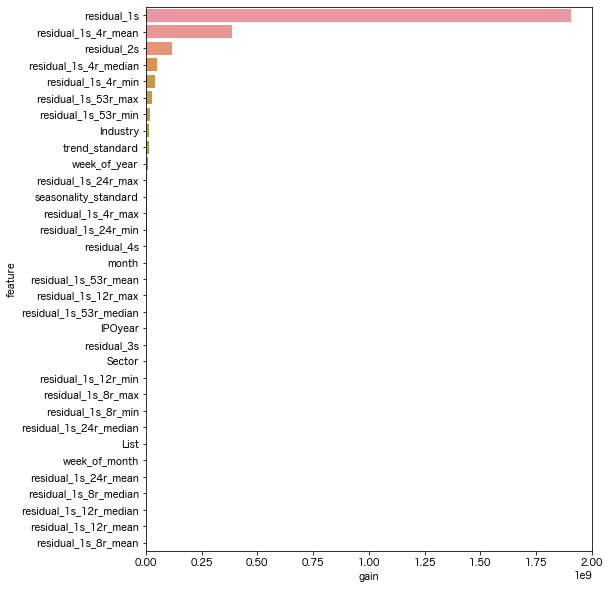

In [55]:
df_imp_ = df_imp_lgb.sort_values("gain", ascending=False)
plt.figure(figsize=(8, 10))
sns.barplot(x=df_imp_["gain"], y=df_imp_["feature"]);

In [56]:
df_test.head(1)

,Date,Symbol,stock_price,List,Sector,Industry,trend,seasonality,residual,IPOyear,year,month,day,week_of_month,week_of_year,trend_standard,seasonality_standard,residual_1s,residual_2s,residual_3s,residual_4s,residual_1s_4r_mean,residual_1s_4r_median,residual_1s_4r_max,residual_1s_4r_min,residual_1s_8r_mean,residual_1s_8r_median,residual_1s_8r_max,residual_1s_8r_min,residual_1s_12r_mean,residual_1s_12r_median,residual_1s_12r_max,residual_1s_12r_min,residual_1s_24r_mean,residual_1s_24r_median,residual_1s_24r_max,residual_1s_24r_min,residual_1s_53r_mean,residual_1s_53r_median,residual_1s_53r_max,residual_1s_53r_min,residual_1s_List_mean,residual_1s_List_median,residual_1s_List_std,residual_2s_List_mean,residual_2s_List_median,residual_2s_List_std,residual_1s_Sector_mean,residual_1s_Sector_median,residual_1s_Sector_std,residual_2s_Sector_mean,residual_2s_Sector_median,residual_2s_Sector_std,residual_1s_Industry_mean,residual_1s_Industry_median,residual_1s_Industry_std,residual_2s_Industry_mean,residual_2s_Industry_median,residual_2s_Industry_std
418,2019/11/17,VGSH,60.375,NASDAQ,unknown,unknown,59.34375,0.24353,0.806152,NaN,2019,11,17,3,46,3.027344,-0.332031,0.832031,0.79248,0.889648,0.814453,0.832031,0.823242,0.889648,0.79248,0.905273,0.900391,1.154297,0.79248,0.943848,0.914062,1.183594,0.79248,1.035156,1.050781,1.263672,0.79248,0.830078,0.847168,1.263672,0.090088,1.439453,0.432129,7.957031,1.322266,0.504883,7.613281,1.248047,0.821777,2.5,1.193359,0.825684,2.386719,1.248047,0.821777,2.5,1.193359,0.825684,2.386719


#### 予測

In [82]:
ins_pred_lgb = PredictModule(config=config_manager, model_type="lightgbm", is_test=True)
df_test_pred_lgb = ins_pred_lgb.predict(model=trained_model_lgb, test_df=df_test)

# df_test_pred_lgb = make_pred_df(
#     model=trained_model_lgb,
#     target=config_manager.pred_cols,
#     df_test=df_test[config_manager.feature_columns.keys()],
#     config=config_manager,
#     is_test=True,
#     cv_num=1
# )

df_test_pred_lgb = pd.merge(
    df_test_pred_lgb,
    df_test[["Date", "Symbol", "trend", "seasonality", "residual", "stock_price"]],
    # df_test[["Date", "Symbol", "stock_price", "stock_price_1s_4r_mean"]],
    how="left",
    on=["Date", "Symbol"]
)

pred residual ...


In [83]:
df_test_pred_lgb.describe()

,cv_num,pred_residual,trend,seasonality,residual,stock_price
count,6556.0,6556.000000,6556.000000,6556.000000,3278.000000,3278.000000
mean,1.0,1.400685,inf,1.230469,1.575195,inf
std,0.0,7.305852,inf,4.457031,8.187500,inf
min,1.0,-86.006692,0.210205,-71.687500,-82.937500,0.119995
25%,1.0,-0.617827,9.037109,-0.068893,-0.726562,8.625000
50%,1.0,0.528874,20.765625,0.556885,0.546875,21.468750
75%,1.0,2.399688,50.000000,2.242188,2.580078,52.968750
max,1.0,66.423919,523.000000,34.593750,85.562500,590.500000


In [84]:
# 検証
from common_module.utils.metrics import calc_rmsle

assess_Date = "2019/11/17"
df_assess = df_test_pred_lgb[df_test_pred_lgb["Date"] == assess_Date].copy()
df_assess["pred_stock_price"] = df_assess["trend"] + df_assess["seasonality"] + df_assess["pred_residual"]
df_assess["pred_stock_price"] = df_assess["pred_stock_price"].clip(lower=0)
# np.sqrt(mean_squared_log_error(y_true, y_pred))
calc_rmsle(y_true=df_assess["stock_price"], y_pred=df_assess["pred_stock_price"])

0.16044861028424365

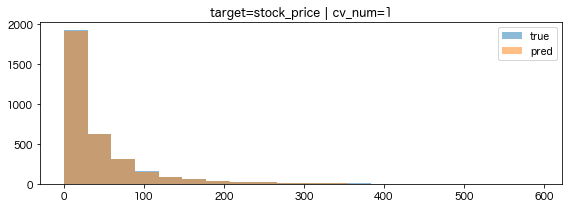

In [88]:
plot_histgram_for_valid(
    data_true=df_assess["stock_price"],
    data_pred=df_assess["pred_stock_price"],
    title=f"target=stock_price | cv_num=1",
    figsize=(8,3)
)

#### 提出

In [85]:
submission_Date = "2019/11/24"
df_submit = df_test_pred_lgb[df_test_pred_lgb["Date"] == submission_Date].copy()
df_submit["pred_stock_price"] = df_submit["trend"] + df_submit["seasonality"] + df_submit["pred_residual"]
df_submit["pred_stock_price"] = df_submit["pred_stock_price"].clip(lower=0)
df_submit = df_submit.rename(columns={"Symbol": "id", "pred_stock_price": "y"})
df_submit_csv = df_submit[["id", "y"]].copy()
df_submit_csv.to_csv("../output/submission_15_lgb.csv", index=False, encoding="utf-8-sig")

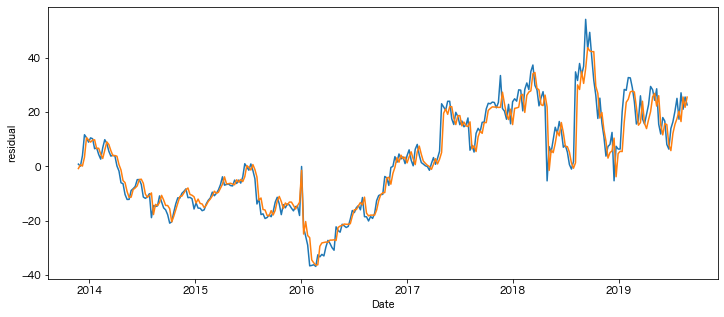

In [109]:
ins_pred_lgb = PredictModule(config=config_manager, model_type="lightgbm", is_test=True)
df_train_pred_lgb = ins_pred_lgb.predict(model=trained_model_lgb, test_df=df_train)
df_train_pred_lgb = pd.merge(
    df_train_pred_lgb,
    df_train[["Date", "Symbol", "trend", "seasonality", "residual", "stock_price"]],
    # df_test[["Date", "Symbol", "stock_price", "stock_price_1s_4r_mean"]],
    how="left",
    on=["Date", "Symbol"]
)

fig, ax = plt.subplots(figsize=(12, 5))
df_single = df_train_pred_lgb[df_train_pred_lgb["Symbol"] == "IAC"].copy()
df_single["Date"] = pd.to_datetime(df_single["Date"].astype("object"))
sns.lineplot(data=df_single, x="Date", y="residual", color="tab:blue")
sns.lineplot(data=df_single, x="Date", y="pred_residual", color="tab:orange");

## xgboost

In [99]:
ins_train_xgb = TrainXGBModule(config=config_manager, target=config_manager.pred_cols)
model_xgb, df_imp_xgb, evals_result = ins_train_xgb.train_model(df_train=df_train, df_val=df_val, have_weight=False)

[0]	train-rmse:5.52977	valid-rmse:5.89053
[108]	train-rmse:1.68277	valid-rmse:2.51669


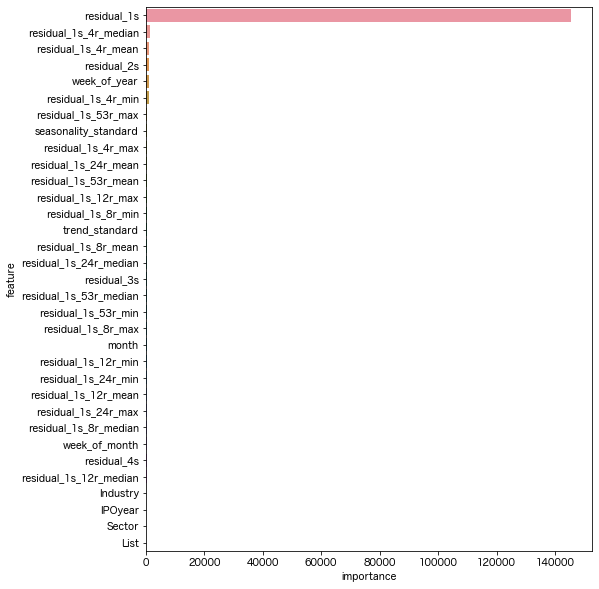

In [100]:
df_imp_ = df_imp_xgb.sort_values("importance", ascending=False)
plt.figure(figsize=(8, 10))
sns.barplot(x=df_imp_["importance"], y=df_imp_["feature"]);

### 予測

In [11]:
ins_pred_xgb = PredictModule(config=config_manager, model_type="xgboost", is_test=True)
df_test_pred_xgb = ins_pred_xgb.predict(model=model_xgb, test_df=df_test)

# df_test_pred_xgb = make_pred_df(
#     model=model_xgb,
#     target=config_manager.pred_cols,
#     df_test=df_test[config_manager.feature_columns.keys()],
#     config=config_manager,
#     is_test=True,
#     cv_num=1
# )

df_test_pred_xgb = pd.merge(
    df_test_pred_xgb,
    df_test[["Date", "Symbol", "stock_price_log1pRate", "stock_price_1s"]],
    # df_test[["Date", "Symbol", "stock_price", "stock_price_1s_4r_mean"]],
    how="left",
    on=["Date", "Symbol"]
)

pred stock_price_log1pRate ...


#### 提出

In [12]:
submission_Date = "2019/11/24"
# stock_price_log1p
df_submission = df_test_pred_xgb[df_test_pred_xgb["Date"] == submission_Date][["Symbol", "pred_stock_price_log1pRate", "stock_price_1s"]].copy()
df_submission["undo_pred_stock_price"] = np.expm1(df_submission["pred_stock_price_log1pRate"]) * df_submission["stock_price_1s"]
df_submission = df_submission.rename(columns={"Symbol": "id", "undo_pred_stock_price": "y"})
df_submission[["id", "y"]].to_csv("../output/submission_14_xgb.csv", index=False, encoding="utf-8-sig")

### Catboost

In [13]:
ins_train_cat = TrainCABModule(config=config_manager, target=config_manager.pred_cols)
model_cat, df_imp_cat = ins_train_cat.train_model(df_train=df_train, df_val=df_val, have_weight=False)

0:	learn: 0.0285935	test: 0.0320712	best: 0.0320712 (0)	total: 527ms	remaining: 43m 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.03194116278
bestIteration = 898

Shrink model to first 899 iterations.


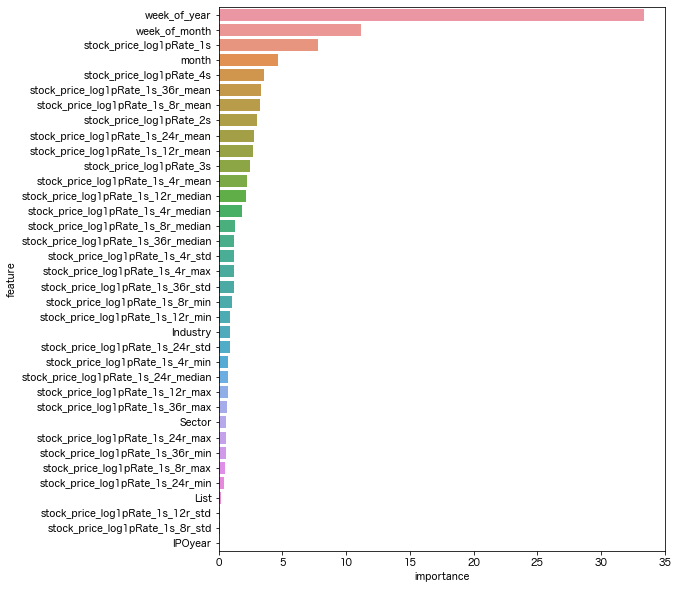

In [14]:
df_imp_ = df_imp_cat.sort_values("importance", ascending=False)
plt.figure(figsize=(8, 10))
sns.barplot(x=df_imp_["importance"], y=df_imp_["feature"]);

In [17]:
ins_pred_cat = PredictModule(config=config_manager, model_type="catboost", is_test=True)
df_test_pred_cat = ins_pred_cat.predict(model=model_cat, test_df=df_test)

# df_test_pred = make_pred_df(
#     model=model_cat,
#     target=config_manager.pred_cols,
#     df_test=df_test[config_manager.feature_columns.keys()],
#     config=config_manager,
#     is_test=True,
#     cv_num=1
# )
df_test_pred_cat = pd.merge(
    df_test_pred_cat,
    df_test[["Date", "Symbol", "stock_price_log1pRate", "stock_price_1s"]],
    # df_test[["Date", "Symbol", "stock_price", "stock_price_1s_4r_mean"]],
    how="left",
    on=["Date", "Symbol"]
)

display(df_test_pred_cat.head())
display(df_test_pred_cat.shape)

pred stock_price_log1pRate ...


,Date,Symbol,cv_num,pred_stock_price_log1pRate,stock_price_log1pRate,stock_price_1s
0,2019/11/17,VGSH,1,0.695956,0.692871,60.406250
1,2019/11/17,JEF,1,0.697744,0.736328,18.968750
2,2019/11/17,IVZ,1,0.697766,0.689941,17.156250
3,2019/11/17,KTCC,1,0.699547,0.655762,5.960938
4,2019/11/17,FBZ,1,0.696500,0.694336,14.726562


(6556, 6)

In [18]:
submission_Date = "2019/11/24"
# stock_price_log1p
df_submission = df_test_pred_cat[df_test_pred_cat["Date"] == submission_Date][["Symbol", "pred_stock_price_log1pRate", "stock_price_1s"]].copy()
df_submission["undo_pred_stock_price"] = np.expm1(df_submission["pred_stock_price_log1pRate"]) * df_submission["stock_price_1s"]
df_submission = df_submission.rename(columns={"Symbol": "id", "undo_pred_stock_price": "y"})
df_submission[["id", "y"]].to_csv("../output/submission_14_cat.csv", index=False, encoding="utf-8-sig")

## アンサンブル

In [19]:
df_sub_lgb = pd.read_csv("../output/submission_14_lgb.csv", encoding="utf-8-sig")
df_sub_xgb = pd.read_csv("../output/submission_14_xgb.csv", encoding="utf-8-sig")
df_sub_cat = pd.read_csv("../output/submission_14_cat.csv", encoding="utf-8-sig")

# rename
df_sub_lgb = df_sub_lgb.rename(columns={"y": "y_lgb"})
df_sub_xgb = df_sub_xgb.rename(columns={"y": "y_xgb"})
df_sub_cat = df_sub_cat.rename(columns={"y": "y_cat"})

# merge & mean
df_sub_all = pd.merge(df_sub_lgb, df_sub_xgb, how="left", on="id")
df_sub_all = pd.merge(df_sub_all, df_sub_cat, how="left", on="id")
df_sub_all["y"] = (df_sub_all["y_lgb"] + df_sub_all["y_xgb"] + df_sub_all["y_cat"]) / 3
df_sub_all[["id", "y"]].to_csv("../output/submission_14_all.csv", index=False, encoding="utf-8-sig")

## visualize

(array([2.799e+03, 3.940e+02, 4.100e+01, 1.800e+01, 9.000e+00, 5.000e+00,
        4.000e+00, 5.000e+00, 2.000e+00, 1.000e+00]),
 array([0.69355786, 0.69400669, 0.69445552, 0.69490434, 0.69535317,
        0.695802  , 0.69625083, 0.69669966, 0.69714848, 0.69759731,
        0.69804614]),
 <BarContainer object of 10 artists>)

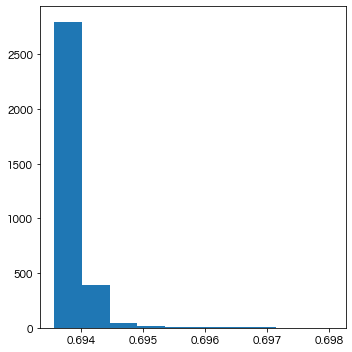

In [79]:
assessment_Date = "2019/11/17"
fig, ax = plt.subplots(figsize=(5,5), tight_layout=True)
ax.hist(df_test_cat_pred[df_test_cat_pred["Date"] == assessment_Date]["pred_stock_price_log1pRate"])
# plot_histgram_for_valid(
#     data_true=df_test_cat_pred[df_test_cat_pred["Date"] == assessment_Date]["stock_price_log1pRate"],
#     data_pred=df_test_cat_pred[df_test_cat_pred["Date"] == assessment_Date]["pred_stock_price_log1pRate"],
#     title=f"target=stock_price | cv_num=1",
#     figsize=(8,3)
# )

In [134]:
# df_test[df_test["Symbol"].isin(["KTCC", "IVZ"])]

In [19]:
df_test_pred = make_pred_df(
    model=trained_model,
    target=config_manager.pred_cols,
    df_test=df_test[config_manager.feature_columns.keys()],
    config=config_manager,
    is_test=True,
    cv_num=1
)
df_test_pred = pd.merge(
    df_test_pred,
    df_test[["Date", "Symbol", "stock_price_log1pRate", "stock_price_1s"]],
    # df_test[["Date", "Symbol", "stock_price", "stock_price_1s_4r_mean"]],
    how="left",
    on=["Date", "Symbol"]
)

display(df_test_pred.head())
display(df_test_pred.shape)

pred stock_price_log1pRate ...


,Date,Symbol,cv_num,pred_stock_price_log1pRate,stock_price_log1pRate,stock_price_1s
0,2019/11/17,VGSH,1,0.694906,0.692871,60.406250
1,2019/11/17,JEF,1,0.698375,0.736328,18.968750
2,2019/11/17,IVZ,1,0.699299,0.689941,17.156250
3,2019/11/17,KTCC,1,0.698542,0.655762,5.960938
4,2019/11/17,FBZ,1,0.695025,0.694336,14.726562


(6556, 6)

In [20]:
df_test_pred.head(30)

,Date,Symbol,cv_num,pred_stock_price_log1pRate,stock_price_log1pRate,stock_price_1s
0,2019/11/17,VGSH,1,0.694906,0.692871,60.406250
1,2019/11/17,JEF,1,0.698375,0.736328,18.968750
2,2019/11/17,IVZ,1,0.699299,0.689941,17.156250
3,2019/11/17,KTCC,1,0.698542,0.655762,5.960938
4,2019/11/17,FBZ,1,0.695025,0.694336,14.726562
5,2019/11/17,PLOW,1,0.695202,0.690918,52.343750
6,2019/11/17,JBK,1,0.698057,0.697266,28.500000
7,2019/11/17,IAC,1,0.696540,0.692871,221.875000
8,2019/11/17,IVR,1,0.696940,0.697754,13.914062
9,2019/11/17,VSH,1,0.695551,0.681152,19.328125


In [18]:
from sklearn.metrics import mean_squared_log_error

assessment_Date = "2019/11/17"

# y_true = df_test_pred[df_test_pred["Date"] == assessment_Date]["stock_price"]
# y_pred = df_test_pred[df_test_pred["Date"] == assessment_Date]["pred_stock_price"]
y_true = df_test_pred[df_test_pred["Date"] == assessment_Date]["stock_price_log1p"]
y_pred = df_test_pred[df_test_pred["Date"] == assessment_Date]["pred_stock_price_log1p"]

RMSLE=np.sqrt(mean_squared_log_error(y_true, y_pred))
print(RMSLE)

0.017857558486342046


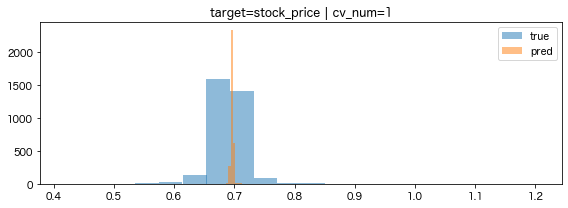

In [21]:
# plot_histgram_for_valid(
#     data_true=df_test_pred[df_test_pred["Date"] == assessment_Date]["stock_price"],
#     data_pred=df_test_pred[df_test_pred["Date"] == assessment_Date]["pred_stock_price"],
#     title=f"target=stock_price | cv_num=1",
#     figsize=(3,3)
# )

assessment_Date = "2019/11/17"
plot_histgram_for_valid(
    data_true=df_test_pred[df_test_pred["Date"] == assessment_Date]["stock_price_log1pRate"],
    data_pred=df_test_pred[df_test_pred["Date"] == assessment_Date]["pred_stock_price_log1pRate"],
    title=f"target=stock_price | cv_num=1",
    figsize=(8,3)
)

In [20]:
# df_pred_20191117 = df_test_pred[df_test_pred["Date"] == assessment_Date].copy()
# convert_columns = ["stock_price", "stock_price_1s_4r_mean"]
# df_pred_20191117[convert_columns] = df_pred_20191117[convert_columns].astype("float64")
# df_pred_20191117.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 0.9, 0.95])

# df_pred_20191117 = df_test_pred[df_test_pred["Date"] == assessment_Date].copy()
# convert_columns = ["stock_price_log1p", "stock_price_log1p_1s_4r_mean"]
# df_pred_20191117[convert_columns] = df_pred_20191117[convert_columns].astype("float64")
# df_pred_20191117.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 0.9, 0.95])

,cv_num,pred_stock_price_log1p,stock_price_log1p,stock_price_log1p_1s_4r_mean
count,3278.0,3278.000000,3278.000000,3278.000000
mean,1.0,3.091253,3.076054,3.079837
std,0.0,1.242718,1.241345,1.230834
min,1.0,0.223194,0.113342,0.147583
10%,1.0,1.306689,1.306836,1.321973
20%,1.0,1.990201,1.973633,1.984766
30%,1.0,2.503921,2.488867,2.492383
40%,1.0,2.802370,2.778906,2.785156
50%,1.0,3.127851,3.112305,3.107422
60%,1.0,3.500577,3.473047,3.470703


In [20]:
def calc_mase(true: pd.Series, pred: pd.Series, mean: pd.Series):
    mase = np.abs(true - pred) / mean
    return mase

df_pred_20191117["mase"] = calc_mase(
    true=df_pred_20191117["stock_price"],
    pred=df_pred_20191117["pred_stock_price"],
    mean=df_pred_20191117["stock_price_1s_4r_mean"]
)

df_pred_20191117 = pd.merge(df_pred_20191117, df_company_features, how="left", on="Symbol")
df_pred_20191117.sort_values("mase", ascending=False).head(20)

KeyError: 'stock_price'

大きい値の予測が大きく外れている。log変換してスケールを小さくする必要がありそう。

## 提出

In [22]:
submission_Date = "2019/11/24"

# # stock_priceのまま
# df_submission = df_test_pred[df_test_pred["Date"] == submission_Date][["Symbol", "pred_stock_price"]].copy()
# df_submission = df_submission.rename(columns={"Symbol": "id", "pred_stock_price": "y"})
# df_submission.to_csv("../output/submission_4.csv", index=False, encoding="utf-8-sig")

# # stock_price_log1p
# df_submission = df_test_pred[df_test_pred["Date"] == submission_Date][["Symbol", "pred_stock_price_log1p"]].copy()
# df_submission["undo_pred_stock_price"] = np.expm1(df_submission["pred_stock_price_log1p"])
# df_submission = df_submission.rename(columns={"Symbol": "id", "undo_pred_stock_price": "y"})
# df_submission[["id", "y"]].to_csv("../output/submission_8.csv", index=False, encoding="utf-8-sig")

# stock_price_log1p
df_submission = df_test_pred[df_test_pred["Date"] == submission_Date][["Symbol", "pred_stock_price_log1pRate", "stock_price_1s"]].copy()
df_submission["undo_pred_stock_price"] = np.expm1(df_submission["pred_stock_price_log1pRate"]) * df_submission["stock_price_1s"]
df_submission = df_submission.rename(columns={"Symbol": "id", "undo_pred_stock_price": "y"})
df_submission[["id", "y"]].to_csv("../output/submission_13.csv", index=False, encoding="utf-8-sig")

In [17]:
df_submission

,id,pred_stock_price_log1pRate,stock_price_1s,y
3278,VGSH,0.693935,60.375000,60.470114
3279,JEF,0.693935,20.640625,20.673142
3280,IVZ,0.693935,17.046875,17.073730
3281,KTCC,0.693935,5.519531,5.528227
3282,FBZ,0.693935,14.765625,14.788887
...,...,...,...,...
6551,TYG,0.693935,16.890625,16.917234
6552,VIRC,0.693935,3.679688,3.685484
6553,BIS,0.693935,14.710938,14.734113
6554,WOOD,0.693935,64.625000,64.726809
